# The Higgs Boson Machine Learning Challenge 
Brighton Nkomo

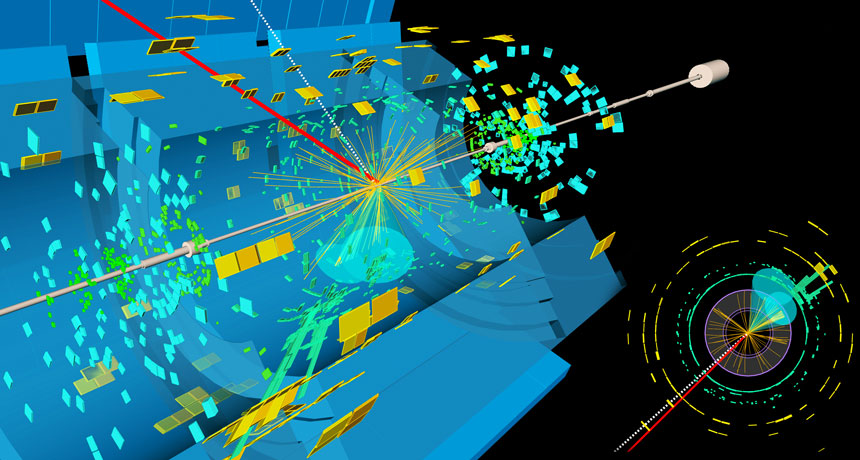

# Introduction 

The Higgs boson has many different processes through which it can decay. When it decays, it produces other particles. In physics, a decay into specific particles is called a _channel_. The Higgs boson has been seen first in three distinct decay channels which are all boson pairs. 

The dataset can be obtained from http://opendata.cern.ch/record/328 and has been built from official ATLAS full-detector simulation, with "Higgs to tautau" events mixed with different backgrounds. The simulator has two parts. In the first, random proton-proton collisions are simulated based on the knowledge that we have accumulated on particle physics. It reproduces the random microscopic explosions resulting from the proton-proton collisions. In the second part, the resulting particles are tracked through a virtual model of the detector. The process yields simulated events with properties that mimic the statistical properties of the real events with additional information on what has happened during the collision, before particles are measured in the detector.

The goal of this project is to essentially classify "tau tau decay of a Higgs boson" versus "background." So this is a binary classification issue and the desired metric to maximize is the _approximate median significance_ (AMS):

$$ \text{AMS} = \sqrt{2\left((s + b + b_r)\log \left( 1 + \frac{s}{b + b_r}\right) -s \right)}$$

where

\\(s, b\\): unnormalized true positive and false positive rates, respectively,
\\(b_r =10\\) is the constant regularization term,
\\(\log\\) is the natural log.
More precisely, let \\( y_1, \dotsc, y_n \in \{\text{b},\text{s}\}^n\\) be the vector of true test labels, let \\( \hat{y}_1, \dotsc, \hat{y}_n \in \{\text{b},\text{s}\}^n\\) be the vector of predicted _submitted_ test labels, and let \\( w_1, \dotsc, w_n \in {\mathbb{R}^+}^n\\) be the vector of weights. Then

$$ s = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{s}\} \mathbb{1}\{\hat{y}_i = \text{s}\}$$

and

$$ b = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{b}\} \mathbb{1}\{\hat{y}_i = \text{s}\}, $$

where the indicator function \\(\mathbb{1}\{A\}\\) is 1 if its argument \\(A\\) is true and 0 otherwise.

__NB:__ I have chosen to work with with the [__Log Loss__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) metric, which is one of the most important classification metrics based on probabilities. Although it's hard to interpret raw log-loss values, but log-loss is still a good metric for comparing models. _For any given problem, a lower log loss value means better predictions_. 

# Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn validation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Sklearn preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize


# Sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Classification metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.metrics import classification_report

# Keras 
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

from sklearn.feature_selection import mutual_info_classif
import utils

# suppress cell warnings
import warnings
warnings.filterwarnings("ignore")

# Read the data

In [2]:
df = pd.read_csv("atlas-higgs-challenge-2014-v2.csv")

In [3]:
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [4]:
df.head(2)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584


Variable Descriptions: 
- EventId - An unique integer identifier of the event.
- DER_mass_MMC - The estimated mass mH of the Higgs boson candidate, obtained through a probabilistic phase space integration.
- DER_mass_transverse_met_lep - The transverse mass between the missing transverse energy and the lepton.
- DER_mass_vis - The invariant mass of the hadronic tau and the lepton.
- DER_pt_h - The modulus of the vector sum of the transverse momentum of the hadronic tau, the lepton and the missing transverse energy vector.
- DER_deltaeta_jet_jet - The absolute value of the pseudorapidity separation between the two jets (undefined if PRI_jet_num ≤ 1).
- DER_mass_jet_jet - The invariant mass of the two jets (undefined if PRI_jet_num $\le 1$).
- DER_prodeta_jet_jet - The product of the pseudorapidities of the two jets (undefined if PRI_jet_num $\le 1$).
- DER_deltar_tau_lep - The R separation between the hadronic tau and the lepton.
- DER_pt_tot - The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num $ \ge $) and the subleading jet (if PRI jet num $= 2$) (but not of any additional jets).
- DER_sum_pt - The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI jet num $ \ge 1$) and the subleading jet (if PRI jet num $= 2$) and the other jets (if PRI jet num $= 3$).
- DER_pt_ratio_lep_tau - The ratio of the transverse momenta of the lepton and the hadronic tau.
- DER_met_phi_centrality - The centrality of the azimuthal angle of the missing transverse energy vector w.r.t. the hadronic tau and the lepton.
- DER_lep_eta_centrality - The centrality of the pseudorapidity of the lepton w.r.t. the two jets (undefined if PRI_jet_num $ \le 1$).
- PRI_tau_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the hadronic tau.
- PRI_tau_eta - The pseudorapidity $\eta$ of the hadronic tau.
- PRI_tau_phi - The azimuth angle $\phi$ of the hadronic tau.
- PRI_lep_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the lepton (electron or muon).
- PRI_lep_eta - The pseudorapidity $\eta$ of the lepton.
- PRI_lep_phi - The azimuth angle $\phi$ of the lepton.
- PRI_met - The missing transverse energy $ E \rightarrow missT$ 
- PRI_met_phi - The azimuth angle $\phi$ of the mssing transverse energy
- PRI_met_sumet - The total transverse energy in the detector.
- PRI_jet_num - The number of jets (integer with value of 0, 1, 2 or 3; possible larger values have been capped at 3).
- PRI_jet_leading_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the leading jet, that is the jet with largest transverse momentum (undefined if PRI_jet_num $ = 0$).
- PRI_jet_leading_eta - The pseudorapidity $\eta$ of the leading jet (undefined if PRI jet num $= 0$).
- PRI_jet_leading_phi - The azimuth angle $\phi$ of the leading jet (undefined if PRI jet num $= 0$).
- PRI_jet_subleading_pt - The transverse momentum $\sqrt{p^{2}_{x} + p^{2}_{y}}$ of the leading jet, that is, the jet with second largest transverse momentum (undefined if PRI_jet_num $\le 1$).
- PRI_jet_subleading_eta - The pseudorapidity $\eta$ of the subleading jet (undefined if PRI_jet_num $\le 1$).
- PRI_jet_subleading_phi - The azimuth angle $\phi$ of the subleading jet (undefined if PRI_jet_num $\le 1$).
- PRI_jet_all_pt - The scalar sum of the transverse momentum of all the jets of the events.
- Weight - The event weight $w_i$
- Label	The event label (string) \\( y_i \in \{\text{b},\text{s}\}\\) (s for signal, b for background).
- KaggleSet	- String specifying to which Kaggle set the event belongs : ”t”:training, ”b”:public leaderboard, ”v”:private leaderboard,”u”:unused.
- KaggleWeight - Weight normalised within each Kaggle dataset.

Since this notebook is not intended for the Kaggle competition, I will drop the KaggleSet and KaggleWeight columns. Also, the `EventId` is a redundant column and would only cause issues when trying to split the data with the stratified_shuffle_split validation method. It only exists for submission purposes.

In [5]:
df.drop(['KaggleSet', 'KaggleWeight', 'EventId'], axis=1, inplace=True )
df.T.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,818228,818229,818230,818231,818232,818233,818234,818235,818236,818237
PRI_jet_subleading_eta,1.24,-999,-999,-999,-999,0.224,0.131,-999,-999,-999,...,-999,-0.124,-1.384,-999,-999,0.787,-2.018,-999,-999,-999
PRI_jet_subleading_phi,-2.475,-999,-999,-999,-999,3.106,-2.767,-999,-999,-999,...,-999,-1.672,2.747,-999,-999,-1.09,2.893,-999,-999,-999
PRI_jet_all_pt,113.497,46.226,44.251,-0,0,193.66,179.877,30.638,0,167.735,...,0,136.986,320.076,110.841,-0,154.056,178.856,-0,30.863,-0
Weight,0.00081448,0.681042,0.715742,1.66065,1.90426,0.0254338,0.00081448,0.00572068,1.6148,0.000461025,...,1.43387,0.000461282,0.301427,0.0195328,1.43312,0.00572068,0.000461282,1.18936,0.51274,1.53121
Label,s,b,b,b,b,b,s,s,b,s,...,b,s,b,b,b,s,s,b,b,b


# Basic Insight of the Dataset

In [6]:
df.dtypes

DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_leading_eta            float64
PRI_jet_leading_phi      

In [7]:
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
DER_mass_MMC,818238.0,-48.82,406.12,-999.00,78.17,105.06,130.73,1949.26
DER_mass_transverse_met_lep,818238.0,49.25,35.38,0.00,19.30,46.48,73.62,968.67
DER_mass_vis,818238.0,81.14,40.58,6.33,59.41,73.74,92.19,1349.35
DER_pt_h,818238.0,57.85,63.41,0.00,14.16,38.47,79.23,2835.00
DER_deltaeta_jet_jet,818238.0,-707.74,454.79,-999.00,-999.00,-999.00,0.50,8.72
DER_mass_jet_jet,818238.0,-600.19,658.72,-999.00,-999.00,-999.00,84.03,4974.98
DER_prodeta_jet_jet,818238.0,-708.68,453.33,-999.00,-999.00,-999.00,-4.55,17.65
DER_deltar_tau_lep,818238.0,2.37,0.78,0.21,1.81,2.49,2.96,5.75
DER_pt_tot,818238.0,18.97,21.92,0.00,2.84,12.38,27.63,2835.00
DER_sum_pt,818238.0,158.60,116.09,46.10,77.49,120.66,200.88,2079.16


In [8]:
#df.info

In [9]:
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

DER_mass_MMC
False    818238
Name: DER_mass_MMC, dtype: int64

DER_mass_transverse_met_lep
False    818238
Name: DER_mass_transverse_met_lep, dtype: int64

DER_mass_vis
False    818238
Name: DER_mass_vis, dtype: int64

DER_pt_h
False    818238
Name: DER_pt_h, dtype: int64

DER_deltaeta_jet_jet
False    818238
Name: DER_deltaeta_jet_jet, dtype: int64

DER_mass_jet_jet
False    818238
Name: DER_mass_jet_jet, dtype: int64

DER_prodeta_jet_jet
False    818238
Name: DER_prodeta_jet_jet, dtype: int64

DER_deltar_tau_lep
False    818238
Name: DER_deltar_tau_lep, dtype: int64

DER_pt_tot
False    818238
Name: DER_pt_tot, dtype: int64

DER_sum_pt
False    818238
Name: DER_sum_pt, dtype: int64

DER_pt_ratio_lep_tau
False    818238
Name: DER_pt_ratio_lep_tau, dtype: int64

DER_met_phi_centrality
False    818238
Name: DER_met_phi_centrality, dtype: int64

DER_lep_eta_centrality
False    818238
Name: DER_lep_eta_centrality, dtype: int64

PRI_tau_pt
False    818238
Name: PRI_tau_pt, dtype: int64

PR

It appears that this dataset has no missing values since and the CERN scientists might have replaced them with an outlier, in particular -999, that is not in the range of the values of the provided features.

In [10]:
for column in df.columns.values.tolist():
    print(column)
    print (len(df[column].loc[df[column] == -999]))
    print("") 

DER_mass_MMC
124602

DER_mass_transverse_met_lep
0

DER_mass_vis
0

DER_pt_h
0

DER_deltaeta_jet_jet
580253

DER_mass_jet_jet
580253

DER_prodeta_jet_jet
580253

DER_deltar_tau_lep
0

DER_pt_tot
0

DER_sum_pt
0

DER_pt_ratio_lep_tau
0

DER_met_phi_centrality
0

DER_lep_eta_centrality
580253

PRI_tau_pt
0

PRI_tau_eta
0

PRI_tau_phi
0

PRI_lep_pt
0

PRI_lep_eta
0

PRI_lep_phi
0

PRI_met
0

PRI_met_phi
0

PRI_met_sumet
0

PRI_jet_num
0

PRI_jet_leading_pt
327371

PRI_jet_leading_eta
327371

PRI_jet_leading_phi
327371

PRI_jet_subleading_pt
580253

PRI_jet_subleading_eta
580253

PRI_jet_subleading_phi
580253

PRI_jet_all_pt
0

Weight
0

Label
0



Based on the summary above, each column has 818238 rows of data, eleven columns that were containing data replaced that has the outlier -999:
<ol>
    <li>"DER_mass_MMC": 124602 row values = -999</li>
    <li>"DER_deltaeta_jet_jet": 580253 row values = -999</li>
    <li>"DER_mass_jet_jet": 580253 row values = -999</li>
    <li>"DER_prodeta_jet_jet" : 580253 row values = -999</li>
    <li>"DER_lep_eta_centrality": 580253 row values = -999</li>
    <li>"PRI_jet_leading_pt": 327371 row values = -999</li>
    <li>"PRI_jet_leading_eta": 327371 row values = -999</li>
    <li>"PRI_jet_leading_phi": 327371 row values = -999</li>
    <li>"PRI_jet_subleading_pt": 580253 row values = -999</li>
    <li>"PRI_jet_subleading_eta": 580253 row values = -999</li>
    <li>"PRI_jet_subleading_phi": 580253 row values = -999</li>
</ol>

NB: For now, I will simply leave these outlier values in my data set.

# Data Visualization 

Now let's see how many rows are there labeled as 's' or 'b'. 

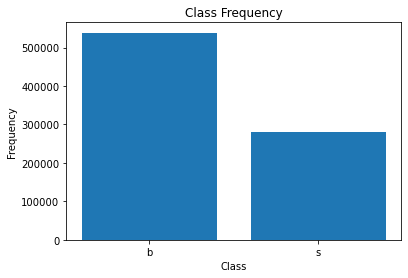

b    538678
s    279560
Name: Label, dtype: int64

In [11]:
unique, counts = np.unique(df['Label'], return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=['b','s'], labels=['b','s'])
#plt.ylim(top=300)
plt.show()
df['Label'].value_counts()

As we can see there are 538678 events labeled as background-b and 279560 events are labeled as signal-s. We clearly have a class imbalance; about a third of the data is the signal-s and the remaining two-thirds of the data is the background-b.

Let's take a look at the correlation between features.

In [12]:
# Calculate the correlation values
feature_cols = df.columns[:-1]
corr_values = df[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

Note that we are interested in the magnitude of the correlation between features, hence the reason why we should look at absolute correlations instead. In other words here, $\mid-0.8\mid = 0.8$. 

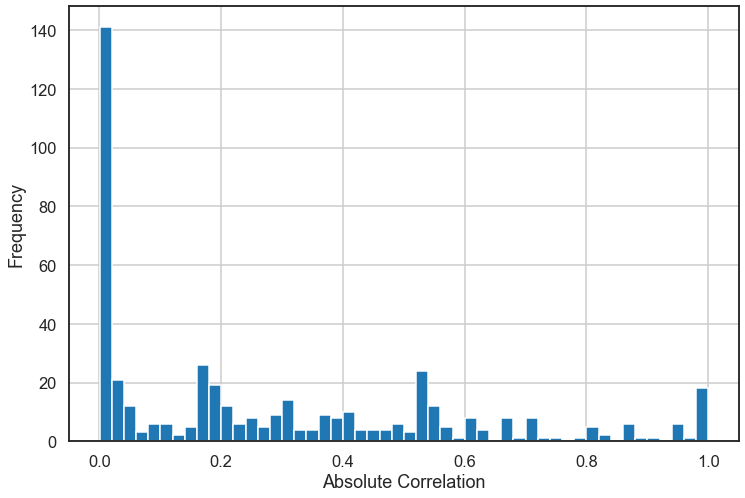

In [13]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

Most of the features have a zero correlation with other features. We are usually interested in features that are strongly correlated to each other or the target variable. Let's take a look at the features that are strongly correlated with each other next.

In [14]:
# The 10 most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8').head(10)

,feature1,feature2,correlation,abs_correlation
121,DER_deltaeta_jet_jet,DER_lep_eta_centrality,0.999998,0.999998
309,DER_lep_eta_centrality,PRI_jet_subleading_phi,0.999998,0.999998
308,DER_lep_eta_centrality,PRI_jet_subleading_eta,0.999997,0.999997
137,DER_deltaeta_jet_jet,PRI_jet_subleading_phi,0.999996,0.999996
136,DER_deltaeta_jet_jet,PRI_jet_subleading_eta,0.999995,0.999995
459,PRI_jet_subleading_eta,PRI_jet_subleading_phi,0.999995,0.999995
444,PRI_jet_leading_eta,PRI_jet_leading_phi,0.999992,0.999992
170,DER_prodeta_jet_jet,DER_lep_eta_centrality,0.999990,0.999990
186,DER_prodeta_jet_jet,PRI_jet_subleading_phi,0.999989,0.999989
185,DER_prodeta_jet_jet,PRI_jet_subleading_eta,0.999988,0.999988


In [15]:
corr_values.shape

(465, 4)

There are 465 pairs of features that show strong positive/negative correlation (i.e, absolute correlation vlaues greater than 0.8) 

# Pre-processing

In [16]:
set(df.Label)

{'b', 's'}

In [17]:
df['Class'] = utils.get_class_ids(df.Label.values)
set(df.Class)

{0, 1}

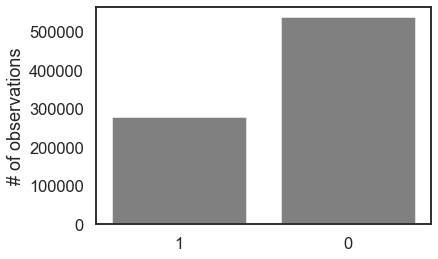

In [18]:
# Get all possible labels
labels = df.Class.unique()
heights = [len(df[df.Class==i]) for i in set(df.Class)] 
plt.bar(labels,heights,color='grey')
plt.xticks(labels,list(set(df.Class)))
plt.ylabel("# of observations")
plt.show()

In [19]:
features = list(set(df.columns) - {'Label', 'Class'})
features

['DER_pt_tot',
 'PRI_met',
 'PRI_met_phi',
 'DER_prodeta_jet_jet',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'PRI_met_sumet',
 'PRI_lep_phi',
 'PRI_jet_all_pt',
 'PRI_jet_leading_phi',
 'PRI_lep_pt',
 'Weight',
 'DER_met_phi_centrality',
 'DER_mass_transverse_met_lep',
 'PRI_tau_phi',
 'PRI_jet_leading_eta',
 'DER_pt_ratio_lep_tau',
 'DER_deltaeta_jet_jet',
 'PRI_lep_eta',
 'DER_mass_MMC',
 'DER_deltar_tau_lep',
 'PRI_jet_num',
 'DER_mass_vis',
 'DER_sum_pt',
 'PRI_tau_eta',
 'DER_pt_h',
 'DER_mass_jet_jet',
 'PRI_jet_subleading_pt',
 'PRI_jet_leading_pt',
 'PRI_tau_pt',
 'DER_lep_eta_centrality']

In [20]:
df.Label.values

array(['s', 'b', 'b', ..., 'b', 'b', 'b'], dtype=object)

Let's take a look at the __mutual information__ to get an idea of which features give the most information about the target variable.

In [21]:
discrete_features = df[features].dtypes == int
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(df[features], df.Class, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

Weight                         0.642913
DER_mass_transverse_met_lep    0.086815
DER_mass_jet_jet               0.079909
PRI_jet_subleading_phi         0.067245
PRI_tau_pt                     0.052750
PRI_jet_leading_phi            0.046603
DER_sum_pt                     0.027829
PRI_met_sumet                  0.018905
PRI_lep_eta                    0.012159
PRI_tau_phi                    0.000904
PRI_met_phi                    0.000164
Name: MI Scores, dtype: float64

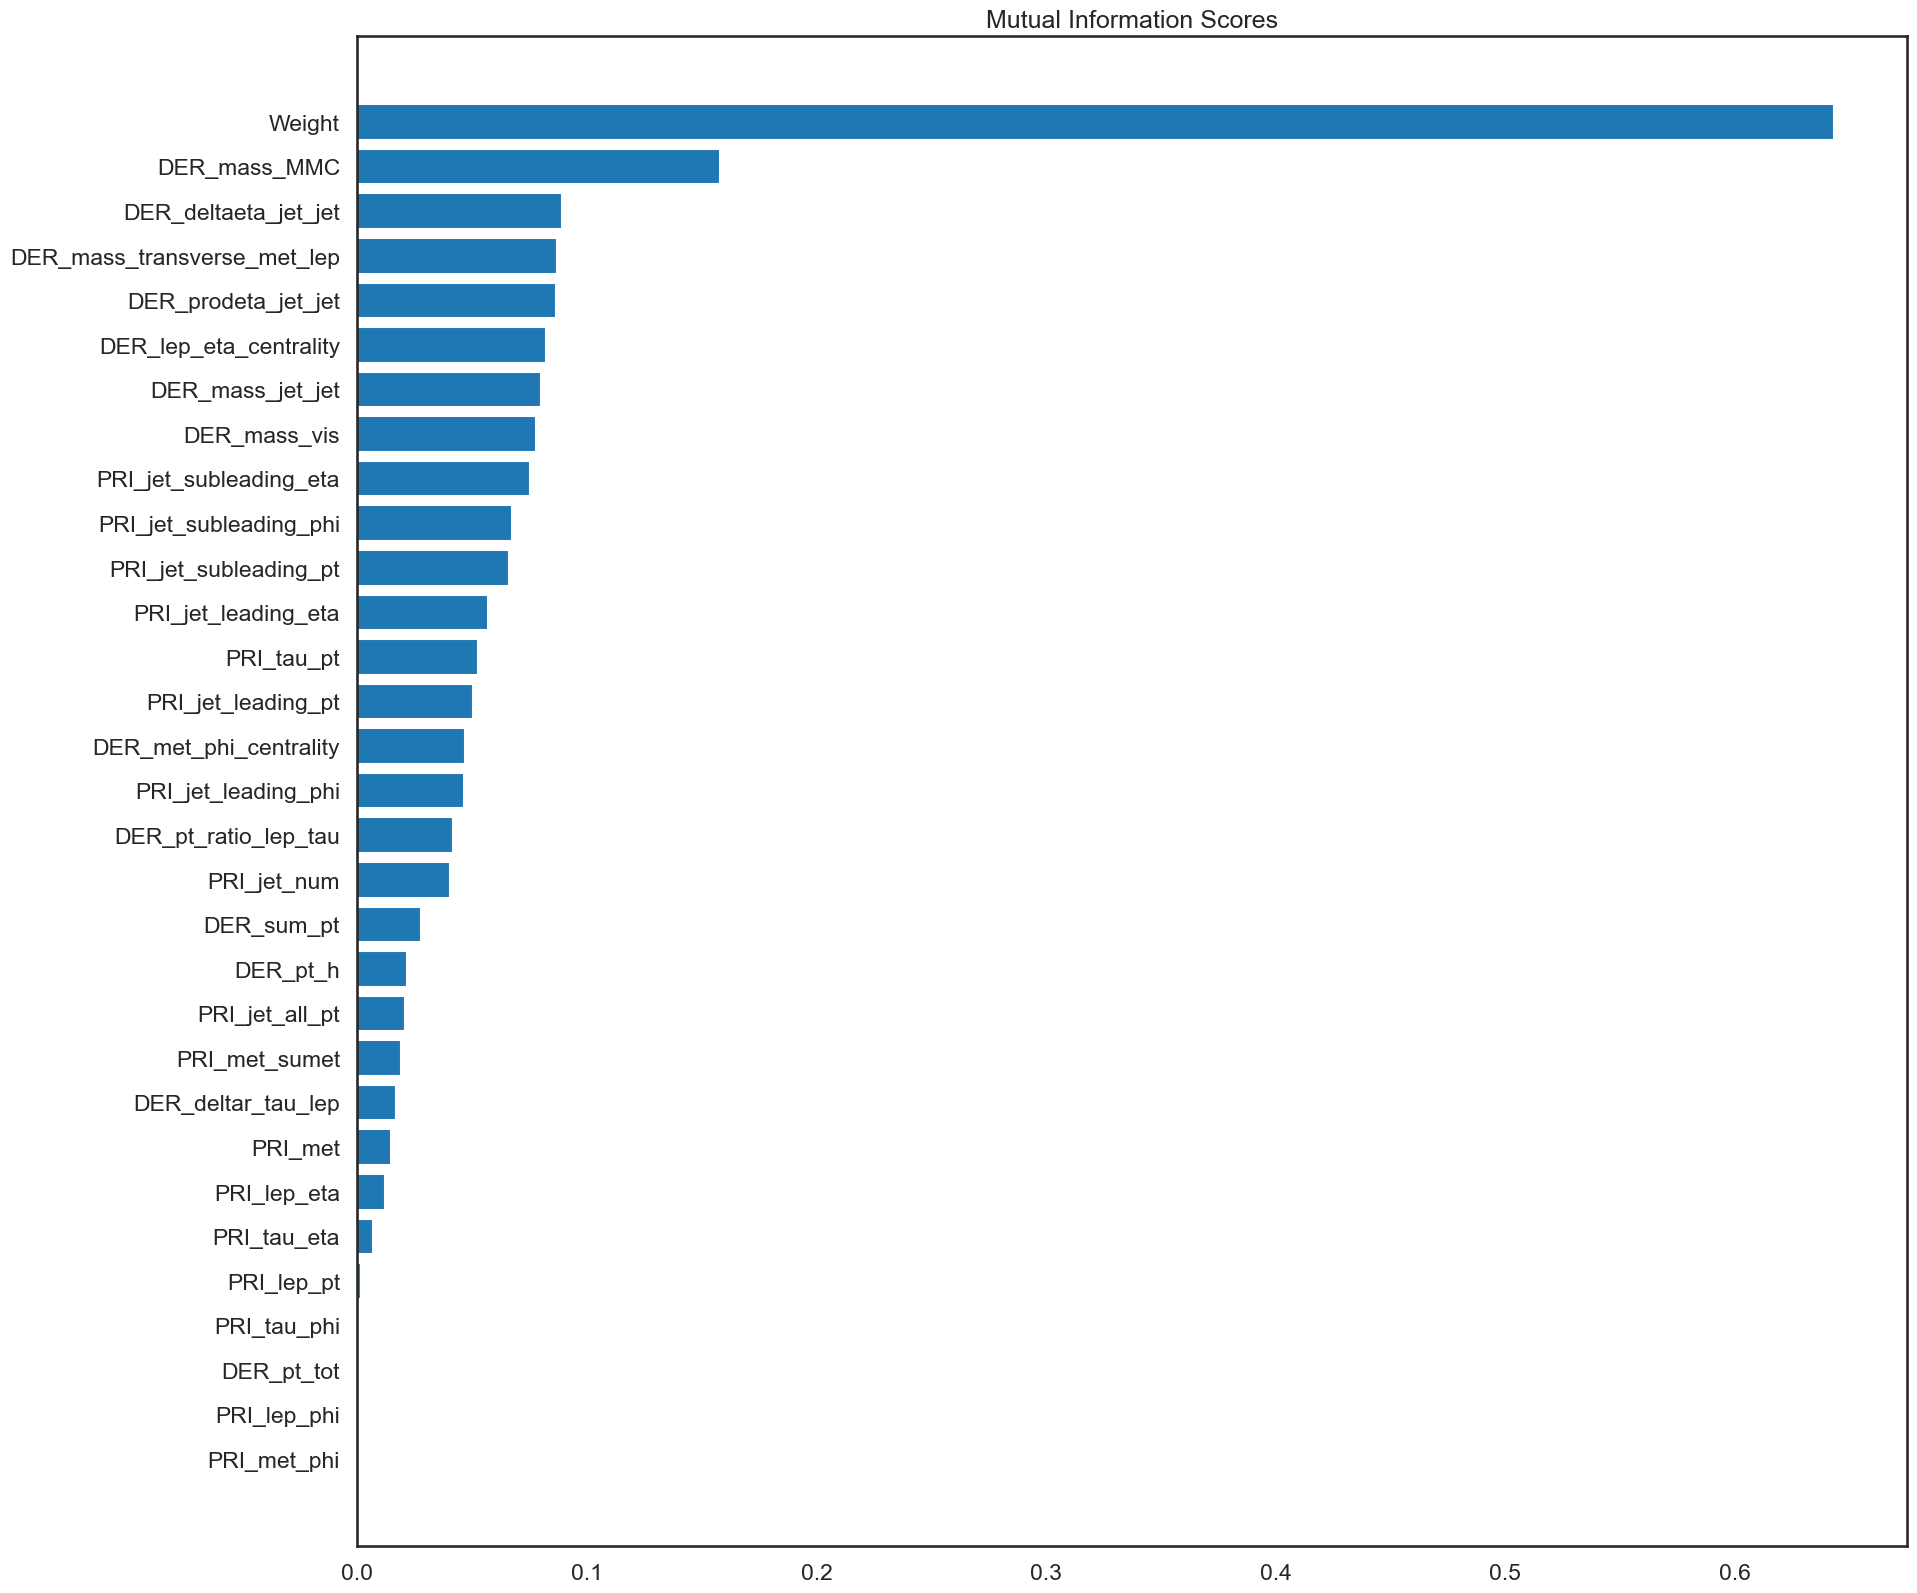

In [22]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(20, 20))
plot_mi_scores(mi_scores)

The `'Weight'` feature contains info about the target variable `'Class'`. Including this feature in our models would lead to a [__data leakage__](https://www.kaggle.com/alexisbcook/data-leakage). This would lead to perfect classifiers. Without removing the weight feature, the models are overly optimistic and the logistic regression model with either L1-regularization or L2-regularization would lead to perfect classifiers. The data leakage could be expained by the following formulas defined at the begining of this notebook: 

Recall that \\( w_1, \dotsc, w_n \in {\mathbb{R}^+}^n\\) is the vector of weights and that

$$ s = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{s}\} \mathbb{1}\{\hat{y}_i = \text{s}\}$$

and

$$ b = \sum_{i=1}^n w_i\mathbb{1}\{y_i = \text{b}\} \mathbb{1}\{\hat{y}_i = \text{s}\}, $$

where the indicator function \\(\mathbb{1}\{A\}\\) is 1 if its argument \\(A\\) is true and 0 otherwise.

It is clear to see that knowing $w_i$ would tell us something about the events being signal 's' or background 'b'. Hence the `Weight` column should be dropped from the features list.


In [23]:
features = list(set(features) - {'Weight'})
features

['DER_pt_tot',
 'PRI_met',
 'PRI_lep_eta',
 'PRI_met_phi',
 'DER_prodeta_jet_jet',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'DER_mass_MMC',
 'PRI_jet_leading_pt',
 'PRI_met_sumet',
 'DER_deltar_tau_lep',
 'PRI_jet_num',
 'PRI_lep_phi',
 'PRI_jet_all_pt',
 'PRI_jet_leading_phi',
 'DER_mass_vis',
 'DER_sum_pt',
 'PRI_tau_eta',
 'PRI_lep_pt',
 'DER_met_phi_centrality',
 'DER_mass_transverse_met_lep',
 'PRI_tau_phi',
 'PRI_jet_leading_eta',
 'DER_pt_h',
 'DER_pt_ratio_lep_tau',
 'DER_mass_jet_jet',
 'PRI_jet_subleading_pt',
 'DER_deltaeta_jet_jet',
 'PRI_tau_pt',
 'DER_lep_eta_centrality']

### Dividing the data into two parts

Since we have an imbalanced dataset, I'll use a stratified shuffle split to maintain the same ratio of classes in the train and validation data.

In [24]:
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.33, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(df[features], df.Class))

# Create the dataframes
X_train = df.loc[train_idx, features]
y_train = df.loc[train_idx, 'Class']

X_test  = df.loc[test_idx, features]
y_test  = df.loc[test_idx, 'Class']

In [25]:
# define the scaler
scaler = MinMaxScaler()
# fit on the training dataset
scaler.fit(X_train)
# scale the training dataset
X_train = scaler.transform(X_train)
# scale the test dataset
X_test = scaler.transform(X_test)

In [26]:
len(X_train), len(X_test)

(548219, 270019)

# Model Building, Training and Evaluation

### Sklearn Classifiers

Now let's look at which model performs best at classifying events in the validation sample. I will seperate this section into 2 parts:
- 1. Linear and non-linear models 
- 2. Tree-based models

### 1. Linear Model: 
#### 1.1 Logistic Regression

In [27]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear', n_jobs=-1).fit(X_train, y_train)

In [28]:
%%time
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', n_jobs=-1).fit(X_train, y_train)

Wall time: 1h 1min 35s


In [29]:
%%time
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear', n_jobs=-1).fit(X_train, y_train)

Wall time: 7min 37s


In [30]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,0,0,0
1,0,1,1
2,1,1,1
3,1,1,1
4,0,0,0


In [31]:
y_prob.head()

,lr,l1,l2
0,0.866795,0.865497,0.865927
1,0.500758,0.502432,0.501243
2,0.568333,0.546216,0.527936
3,0.506831,0.511187,0.543440
4,0.870799,0.878518,0.879041


In [32]:
log_loss(y_test, y_pred['l1'])

8.642088301605265

In [33]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [34]:
metrics

,lr,l1,l2
precision,0.741427,0.741876,0.742223
recall,0.749510,0.749788,0.750106
fscore,0.740567,0.741529,0.741863
accuracy,0.749510,0.749788,0.750106
auc,0.694590,0.696530,0.696897


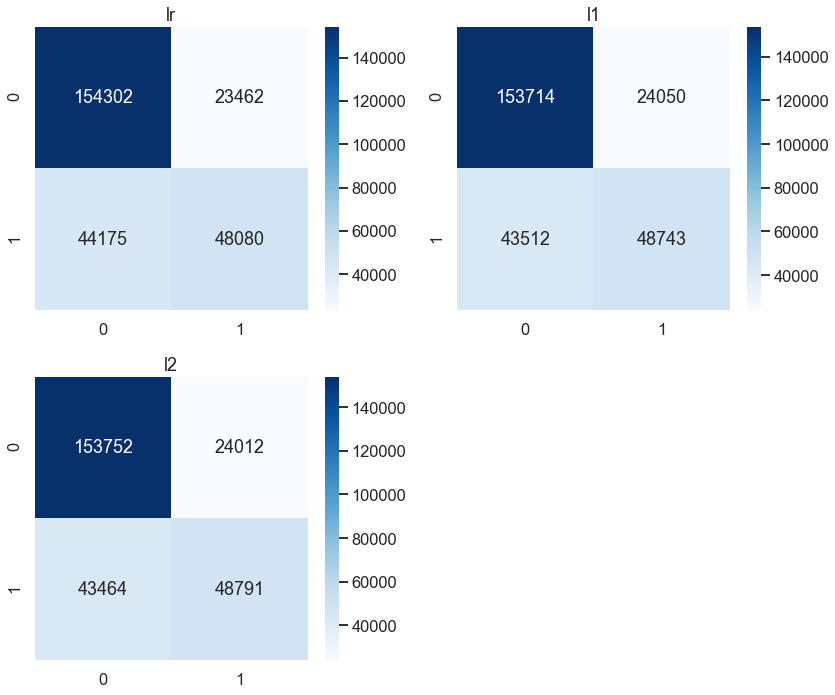

In [35]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')
for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap='Blues');
    ax.set(title=lab);
    
plt.tight_layout()

The logistic regression models using the L1-regularization technique, also called Lasso Regression, or the L2-regularization technique (Ridge regression), both perform better at classifying true positives than the regular logistic regression model.

### 3. k-Nearest Neighbors

In [36]:
from sklearn.neighbors import KNeighborsClassifier

To determine the right value for K, I'll have to examine results for values of K from 1 to 40. I'll focus on the Log-loss metric.

In [37]:
max_k = 30
error_rates = list() # log-loss

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn = knn.fit(X_train, y_train)
    
    proba_knn = knn.predict_proba(X_test)
    error = round(log_loss(y_test, proba_knn), 4)
    error_rates.append((k, error))

error_results = pd.DataFrame(error_rates, columns=['K', 'Log loss'])

KeyboardInterrupt: 

In [ ]:
# Plot Log loss results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(color=colors[0], figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Log loss')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

In [ ]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

In [ ]:
proba_knn = knn.predict_proba(X_test)
print('Log-loss: ', log_loss(y_test, proba_knn))

In [ ]:
sns.set_context('talk')
cm_knn = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')

### 3. Tree-Based Model: Boosted Decision Tree

In [ ]:
%%time 
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=400, subsample=0.3, max_features = 5, random_state=42)
gb.fit(X_train, y_train)

In [ ]:
# predict each event
proba_gb = gb.predict_proba(X_test)

In [ ]:
log_loss(y_test, proba_gb)

In [ ]:
y_pred = gb.predict(X_test)
print(classification_report(y_pred, y_test))

In [ ]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

### 4. Keras Neural Network 

In [ ]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim))
    model.add(Activation('relu'))

    model.add(Dense(60))
    model.add(Activation('relu'))

    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    return model

In [ ]:
nn = nn_model(len(features))
nn.fit(X_train, np_utils.to_categorical(y_train), verbose=1, epochs=20, batch_size=500)

In [ ]:
# predict each event
proba_nn = nn.predict(X_test)

In [ ]:
log_loss(y_test, proba_nn)

In [ ]:
pred_nn = proba_nn.argmax(axis=-1)
print(classification_report(pred_nn, y_test))

In [ ]:
sns.set_context('talk')
cm_nn = confusion_matrix(y_test, pred_nn)
ax = sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')

# Hyperparameter Tunning

The gradient boosting model was the best model, so I will focus only on it when fine-tunning hyperparameters.

In [ ]:
error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [50, 100, 200, 400, 600, 1000]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(max_features = 5, n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train, y_train)
    y_pred = GBC.predict_proba(X_test)

    # Get the error
    error = log_loss(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

In [ ]:
sns.set_context('talk')
sns.set_style('white')
sns.color_palette("Blues", as_cmap=True)

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

Now I will perform __Grid Search__ to find the best parameters to use for this gradient boosting model, hence the best gradient boosting model.

In [ ]:
# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 3, 5, 7]}

# Log loss metric
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring=LogLoss, 
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [ ]:
# The best model
GV_GBC.best_estimator_

# Quality Metrics

The error metrics. Classification report is particularly convenient for multi-class cases, however I will use it even for the binary-class because it is still convenient nonetheless.

In [ ]:
y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

Now I will plot the confusion matrix.

In [ ]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    Now I'll plot ROC curves and signal efficiency dependence from particle mometum and transverse momentum values.

In [ ]:
# best model
proba = GV_GBC.predict_proba(X_test)

In [ ]:
utils.plot_roc_curves(proba, y_test)

In [ ]:
log_loss(y_test, proba)